In [3]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.regularizers import l2
from keras.layers import Dropout
import tensorflow as tf
from keras.models import load_model
import pandas_ta as ta




In [39]:
df = pd.read_csv('BTC-USDday.csv')
df['RSI'] = ta.rsi(df['Close'], length=100)
df['EMAF'] = ta.ema(df['Close'], length=20)
df['EMAM'] = ta.ema(df['Close'], length=50)
df['EMAS'] = ta.ema(df['Close'], length=100)
df = df.drop(columns=['Volume'])
df = df.drop(columns=['Date'])
df_set = df.iloc[200: , 0:10]
print(type(df_set))

print(df_set.shape)
sc = MinMaxScaler(feature_range=(0,1))
df_scaled = sc.fit_transform(df_set)

open = np.array(df_scaled[:, 0])
high = np.array(df_scaled[:, 1])
low = np.array(df_scaled[:, 2])
close = np.array(df_scaled[:, 3])
adj_close = np.array(df_scaled[:, 4])
date = np.array(df.index) #行数
rsi = np.array(df_scaled[:, 5])
emaf = np.array(df_scaled[:, 6])
emam = np.array(df_scaled[:, 7])
emas = np.array(df_scaled[:, 8])

<class 'pandas.core.frame.DataFrame'>
(3200, 9)


In [40]:
X = []
y = []
for i in range(len(open)-216):
    X_i = np.vstack((open[i:i+185], high[i:i+185], low[i:i+185], close[i:i+185], adj_close[i:i+185], rsi[i:i+185], emaf[i:i+185], emam[i:i+185], emas[i:i+185])).T
    Y_i = adj_close[i+215]
    X.append(X_i)
    y.append(Y_i)
X = np.array(X)
y = np.array(y)

X.shape

# X[i] = 过去1年里的ohlc和adj_c
# y[i] = 第30天的adj_c

(2984, 185, 9)

In [41]:
train_ratio = 0.6
cv_ratio = 0.2

num_samples = 2984
num_train_samples = int(num_samples * train_ratio)
num_cv_samples = int(num_samples * cv_ratio)
indices = np.random.permutation(num_samples)

X_train = X[indices[:num_train_samples]]
y_train = y[indices[:num_train_samples]]
X_cv = X[indices[num_train_samples:num_train_samples + num_cv_samples]]
y_cv = y[indices[num_train_samples:num_train_samples + num_cv_samples]]
X_test = X[indices[num_train_samples + num_cv_samples:]]
y_test = y[indices[num_train_samples + num_cv_samples:]]

print(X_train.shape, X_cv.shape, X_test.shape, y_test.shape)

(1790, 185, 9) (596, 185, 9) (598, 185, 9) (598,)


In [29]:
model = Sequential()
model.add(LSTM(250, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(50,kernel_regularizer=l2(0.001)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, validation_data=(X_cv, y_cv), epochs=60, batch_size=64)
model.save('daily_trained_1Y-1M_model.h5')

Epoch 1/60
28/28 [==============================] - 13s 431ms/step - loss: 0.0767 - val_loss: 0.0643
Epoch 2/60
28/28 [==============================] - 12s 436ms/step - loss: 0.0592 - val_loss: 0.0538
Epoch 3/60
28/28 [==============================] - 12s 438ms/step - loss: 0.0496 - val_loss: 0.0451
Epoch 4/60
28/28 [==============================] - 13s 452ms/step - loss: 0.0415 - val_loss: 0.0375
Epoch 5/60
28/28 [==============================] - 13s 452ms/step - loss: 0.0353 - val_loss: 0.0318
Epoch 6/60
28/28 [==============================] - 13s 463ms/step - loss: 0.0297 - val_loss: 0.0267
Epoch 7/60
28/28 [==============================] - 14s 496ms/step - loss: 0.0248 - val_loss: 0.0224
Epoch 8/60
28/28 [==============================] - 14s 502ms/step - loss: 0.0212 - val_loss: 0.0202
Epoch 9/60
28/28 [==============================] - 14s 500ms/step - loss: 0.0181 - val_loss: 0.0168
Epoch 10/60
28/28 [==============================] - 14s 491ms/step - loss: 0.0159 - val_lo

/Users/guanyulu/anaconda3/envs/btcp/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [46]:

test_predict = model.predict(X_test)
original_shape_array = np.zeros((len(test_predict), 9))
original_shape_array[:, 0] = test_predict.ravel()
yhat = sc.inverse_transform(original_shape_array)
yhat = yhat[:,0]
print(yhat.shape)


original_shape_y = np.zeros((len(y_test), 9))
original_shape_y[:,0] = y_test
y_test_original = sc.inverse_transform(original_shape_y)
y_test_original = y_test_original[:,0]
print(y_test_original.shape)

mse = np.mean((y_test_original - yhat) ** 2)
mse





19/19 [==============================] - 1s 73ms/step
(598,)
(598,)


615178.9396449912

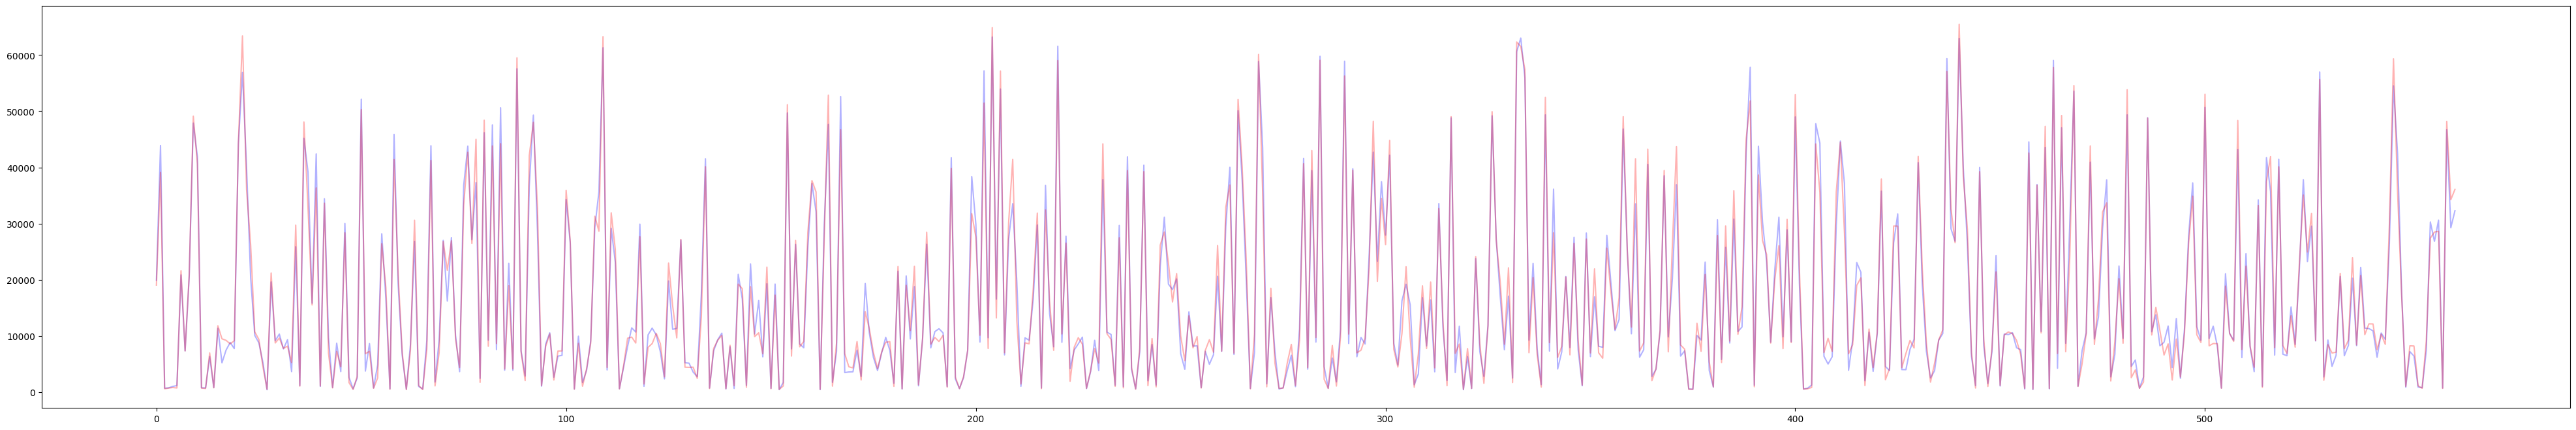

In [141]:
plt.figure(figsize=(50,8))
plt.plot(y_test_original,color = 'blue', alpha=0.3, label='predict')
plt.plot(yhat, color = "red",alpha=0.3, label='actuall')

In [21]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Learning Curve')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()


NameError: name 'history' is not defined

In [48]:
latest_data = df[-186:-1]  # 获取最后31行数据
latest_data_scaled = sc.fit_transform(latest_data)

# 构建输入数据，这里需要注意维度匹配
X_latest = np.array([latest_data_scaled])
X_latest = np.reshape(X_latest, (1, 185, 9))  # 1个样本，365个时间步，每步9个特征

# 使用模型进行预测
predicted_price = model.predict(X_latest)
print(predicted_price)
# 反归一化预测结果以获取实际的价格
predicted_price_original = sc.inverse_transform(np.hstack((predicted_price, np.zeros((predicted_price.shape[0], 8)))))
predicted_price_original = predicted_price_original[:, 0]

# 输出预测的闭市价
print(f"Predicted closing price for the next day: {predicted_price_original[0]}")


1/1 [==============================] - 0s 59ms/step
[[0.7148191]]
Predicted closing price for the next day: 39314.75019352719
